In [445]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
sns.set_style('darkgrid')
%matplotlib inline

X = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
Test_X = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )
X.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
Test_X.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)


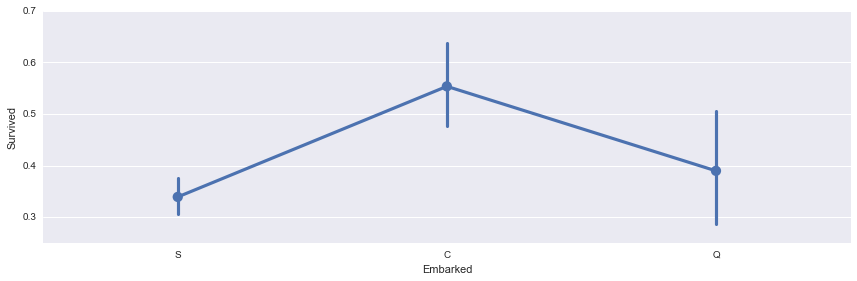

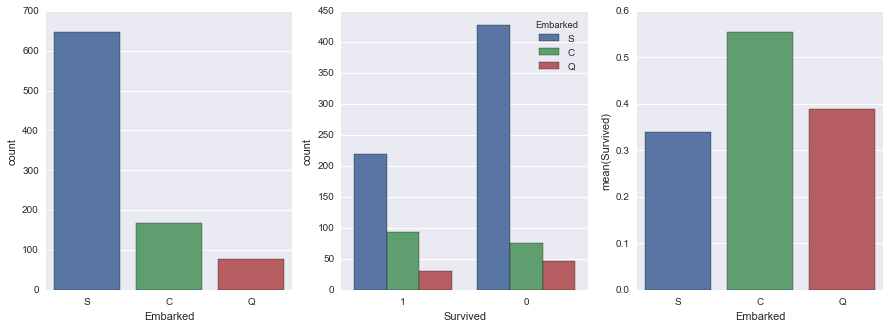

In [446]:
# Embarked 

# Only in titanic_df, fill the two missing values with the most 
# occured value, which is "S".
X["Embarked"] = X["Embarked"].fillna("S")

sns.factorplot('Embarked', 'Survived', data=X,size=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=X, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=X, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = X[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_titanic  = pd.get_dummies(X['Embarked'])
embark_dummies_titanic.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(Test_X['Embarked'])
embark_dummies_test.drop(['S'], axis=1, inplace=True)

X = X.join(embark_dummies_titanic)
Test_X = Test_X.join(embark_dummies_test)

X.drop(['Embarked'], axis=1,inplace=True)
Test_X.drop(['Embarked'], axis=1,inplace=True)

In [447]:
X['Age'] = X['Age'].fillna(X.Age.mean())
Test_X['Age'] = Test_X['Age'].fillna(Test_X.Age.mean())
Test_X['Cabin']
X.pop('Cabin')
Test_X.pop('Cabin')

variable = 'Sex'
X[variable].fillna("Missing", inplace=True)
Test_X[variable].fillna("Missing", inplace=True)
dummies = pd.get_dummies(X[variable], prefix=variable)
Test_dummies = pd.get_dummies(Test_X[variable], prefix=variable)
X = pd.concat([X, dummies], axis=1)
Test_X = pd.concat([Test_X, Test_dummies], axis = 1)
X.drop([variable], axis=1, inplace=True)
Test_X.drop([variable], axis=1, inplace=True)

X['Fare'].fillna(X.Fare.median(), inplace=True)
Test_X['Fare'].fillna(X.Fare.median(), inplace=True)


In [448]:
count = 0
for fare in X.Fare:
    if fare == 0:
        count = count + 1
    fare = X.Fare.median()
print(count)

15


In [449]:
X.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.352413,0.647587
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.477990,0.477990
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000


/Users/tedrand/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


[<matplotlib.text.Text at 0x1281986d8>, <matplotlib.text.Text at 0x1281aee48>]

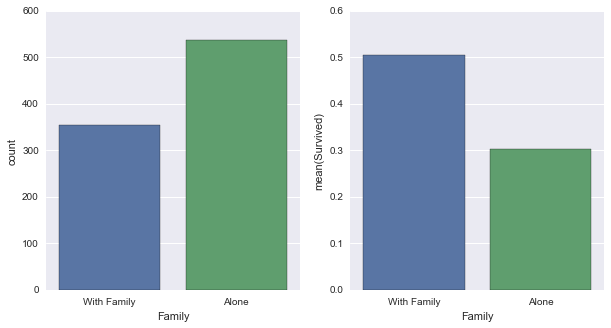

In [450]:
X['Family'] = X['Parch'] + X['SibSp']
X['Family'].loc[X['Family'] > 0] = 1
X['Family'].loc[X['Family'] == 0] = 0

Test_X['Family'] = Test_X['Parch'] + Test_X['SibSp']
Test_X['Family'].loc[Test_X['Family'] > 0] = 1
Test_X['Family'].loc[Test_X['Family'] == 0] = 0

# plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

# sns.factorplot('Family',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Family', data=X, order=[1,0], ax=axis1)

# average of survived for those who had/didn't have any family member
family_perc = X[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

In [451]:
y = X.pop('Survived')
reg = RandomForestRegressor(n_estimators=1000,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=42,
                             max_features="auto",
                             min_samples_leaf=5)
reg.fit(X, y)
roc = roc_auc_score(y, reg.oob_prediction_)
print("C-stat: ",roc)

C-stat:  0.872080017895


In [452]:
model = RandomForestClassifier(n_estimators=1000,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=42,
                             max_features="auto",
                             min_samples_leaf=5)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [453]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,C,Q,Sex_female,Sex_male,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.188552,0.086420,0.352413,0.647587,0.397306
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.391372,0.281141,0.477990,0.477990,0.489615
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [454]:
output = model.predict(Test_X).astype(int)
X_test_cp = pd.read_csv('../input/test.csv')
p_id = X_test_cp['PassengerId']
submission = pd.DataFrame({ 'PassengerId': p_id,
                            'Survived': output})
submission.to_csv("rand.csv", index=False)
print ("done")

done
